In [4]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector
import tensorflow as tf
import os
from keras.layers import TimeDistributed
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from matplotlib import pyplot as plt


In [4]:
"""
Old Data

urllib.request.urlretrieve('https://raw.githubusercontent.com/FGiuliari/Trajectory-Transformer/master/datasets/eth/train/students001_train.txt', 'dataset.txt')
data = pd.read_csv("dataset.txt", sep="\t", header=None)
data.columns = ["Frame", "Ped", "X", "Y"]
minx = data["X"].min()
miny = data["Y"].min()
data["X"] = data["X"] + abs(minx)
data["Y"] = data["Y"] + abs(miny)
"""

'\nOld Data\n\nurllib.request.urlretrieve(\'https://raw.githubusercontent.com/FGiuliari/Trajectory-Transformer/master/datasets/eth/train/students001_train.txt\', \'dataset.txt\')\ndata = pd.read_csv("dataset.txt", sep="\t", header=None)\ndata.columns = ["Frame", "Ped", "X", "Y"]\nminx = data["X"].min()\nminy = data["Y"].min()\ndata["X"] = data["X"] + abs(minx)\ndata["Y"] = data["Y"] + abs(miny)\n'

In [5]:
"""
New Data
"""
data = pd.read_csv("traj_data_v1.csv")
data.describe()

,Unnamed: 0,Vehicle_ID,X,Y,X_REL,Y_REL
count,134363.000000,134363.000000,1.343630e+05,1.343630e+05,134363.000000,134363.000000
mean,67181.000000,1522.586002,6.037205e+06,1.893112e+06,25.013277,-20.563577
std,38787.401447,906.737134,1.109129e+06,1.831537e+05,34.361927,63.308456
min,0.000000,2.000000,2.230484e+06,1.375551e+06,-104.242000,-329.272000
25%,33590.500000,753.000000,6.042875e+06,1.873242e+06,-0.464000,-58.563500
50%,67181.000000,1479.000000,6.451159e+06,1.873308e+06,14.445000,-18.858000
75%,100771.500000,2262.000000,6.451216e+06,1.874247e+06,42.681000,12.638500
max,134362.000000,3363.000000,6.452528e+06,2.133628e+06,236.273000,366.318000


In [6]:
len(data['Vehicle_ID'].unique())

2691

In [7]:
"""
Preprocess data, removed torch tensors return type, now np arrays
"""
def preprocess_dataset(data, max = 10, max_len = 40, input_len = 30):
    scaler = MinMaxScaler(feature_range=(0, max))
    data[['X_REL', 'Y_REL']] = scaler.fit_transform(data[['X_REL', 'Y_REL']])
    global map_dict
    map_dict = {}
    unique_peds = data['Vehicle_ID'].unique()
    unique_peds = sorted(unique_peds)
    inputs = []
    outputs = []
    seq = []
    for ped in unique_peds:
        if (len(data[data['Vehicle_ID'] == ped]) >= max_len):
          seq_inner = []
          target_inner = 0
          i = 0
          for indx, row in data[data['Vehicle_ID'] == ped].iterrows():
            x = round(row['X_REL'])
            y = round(row['Y_REL'])
            ## Cantor pairing function:
            bin = y * max + x
            #print("X: ", x, " Y: ", y, " Bin: ", bin)
            map_dict[int(bin)] = [int(x), int(y)]
            i += 1
            if i == max_len:
              break
            seq_inner.append(int(bin))
          inputs.append([seq_inner[0:input_len]])
          outputs.append([seq_inner[input_len + 1:]])
    train_inputs, test_inputs = train_test_split(inputs, train_size=0.7)
    train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, outputs, train_size=0.8)
    
    return np.array(train_inputs), np.array(test_inputs), np.array(train_targets), np.array(test_targets)

In [10]:
train_data_inputs, test_data_inputs, train_data_targets, test_data_targets = preprocess_dataset(data, max = 50, max_len = 42, input_len = 20)

In [11]:
print(train_data_inputs.shape)
print(train_data_targets.shape)
train_data_inputs = train_data_inputs.reshape(train_data_inputs.shape[0], train_data_inputs.shape[2], 1)
train_data_targets = train_data_targets.reshape(train_data_targets.shape[0], train_data_targets.shape[2], 1)
print(train_data_inputs.shape)
print(train_data_targets.shape)

(2146, 1, 20)
(2146, 1, 20)
(2146, 20, 1)
(2146, 20, 1)


In [12]:
print(test_data_inputs.shape)
print(test_data_targets.shape)
test_data_inputs = test_data_inputs.reshape(test_data_inputs.shape[0], test_data_inputs.shape[2], 1)
test_data_targets = test_data_targets.reshape(test_data_targets.shape[0], test_data_targets.shape[2], 1)
print(test_data_inputs.shape)
print(test_data_targets.shape)

(537, 1, 20)
(537, 1, 20)
(537, 20, 1)
(537, 20, 1)


In [123]:
#SOURCE: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

input_steps = 20
prediction_steps = 28
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(input_steps, 1), return_sequences=True))
model.add(LSTM(50, activation='relu', input_shape=(input_steps, 1), return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(prediction_steps, activation=''))
model.compile(optimizer='adam', loss='CategoricalCrossentropy')

In [124]:
history = model.fit(
    train_data_inputs,
    train_data_targets,
    batch_size=1,
    epochs=5,
    validation_data=(test_data_inputs, test_data_targets),
)

Epoch 1/5
1544/1544 [==============================] - 21s 13ms/step - loss: 316119.6250 - val_loss: 334128.1562
Epoch 2/5
1544/1544 [==============================] - 21s 14ms/step - loss: 328352.7812 - val_loss: 334128.1562
Epoch 3/5
1544/1544 [==============================] - 21s 14ms/step - loss: 328352.7812 - val_loss: 334128.1562
Epoch 4/5
1544/1544 [==============================] - 21s 13ms/step - loss: 328352.9062 - val_loss: 334128.1562
Epoch 5/5
1544/1544 [==============================] - 21s 13ms/step - loss: 328352.5312 - val_loss: 334128.1562


In [105]:
history.history

{'loss': [235676.25, 159949.28125, 68750.9140625, 69311.671875, 70363.1015625],
 'val_loss': [213953.09375,
  89705.7578125,
  83887.625,
  88638.390625,
  98400.2265625]}

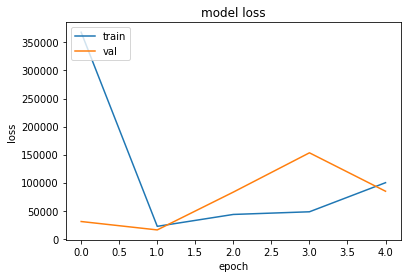

In [110]:
#plotting losses, https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [90]:
def reshape_data(inp_data):
  inp_data = inp_data.reshape(1, max(inp_data.shape), 1)
  return inp_data

In [114]:
a = reshape_data(test_data_inputs[3])
a.shape

(1, 20, 1)

In [115]:
a_pred = model.predict(a)

In [116]:
print(a_pred,test_data_targets[2])

[[1275.4198 1272.4205 1263.0336 1265.2559 1262.1179 1262.1694 1252.4054
  1255.7395 1253.8356 1247.8873 1238.374  1249.3221 1241.7749 1245.1742
  1237.1626 1233.176  1238.2358 1229.9415 1231.0162 1227.644  1227.631
  1225.7924 1220.6101 1226.564  1220.9342 1219.5354 1216.847  1216.0085]] [[1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]
 [1316]]


In [30]:
test_data_targets[1] - a_pred

array([[ -8.91870117,   0.97741699,  -0.72619629,  -0.74133301,
         11.90002441,  -2.83618164,   0.73034668, -16.70373535,
        -11.92407227,   1.74621582, -11.91918945,  -7.98608398,
          4.1003418 ,  -5.34277344,  -0.8560791 ,  -5.68395996,
         -2.33459473, -13.78076172,  -5.15612793, -13.86950684,
         -3.41381836, -16.2677002 , -10.04638672,  -9.99963379,
         -5.36425781, -10.18566895,  -0.89611816,  -7.35705566]])

1
1
1
1
1


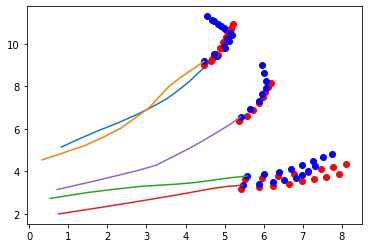

In [ ]:
for i in range(90,95):
  plot_prediction(i, scaled = False)

In [ ]:
def plot_prediction(test_index = 0, scaled = False):
  m = my_max
  i = inputs_scaled
  o = outputs_scaled
  if scaled == False:
    m = 1
    i = inputs
    o = outputs
  print(m)
  test_ind = test_index
  t = i[test_ind]
  t = t.reshape(1, 12, 2)
  b = model.predict(t)
  b = np.squeeze(b)
  xx = b[:,0] * m
  yy = b[:,1] * m
  check_tar = o[test_ind] * m
  check_input = i[test_ind] * m
  plt.plot(xx, yy, 'ro')
  plt.plot(check_tar[:,0], check_tar[:,1], 'bo')
  plt.plot(check_input[:,0], check_input[:,1])

In [14]:
# embedding

len(train_data_inputs[1])
train_data_inputs.shape

(2146, 20, 1)

In [13]:
def make_one_hot(inp):
  one_hot_vector = np.zeros(max(map_dict)+1)
  result = []
  for i in inp:
    inner = []
    for coord in i:
      one_hot_vector[coord] = 1
      inner.append(one_hot_vector)
    result.append(inner)
  return np.array(result)

In [15]:
ti = make_one_hot(train_data_inputs)
tt = make_one_hot(train_data_targets)

In [16]:
print(ti.shape)
print(tt.shape)

(2146, 20, 2311)
(2146, 20, 2311)


In [23]:
vocab_size = max(map_dict) +1
seq_len = 20
train_inputs = ti
train_targets =tt

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
model = Sequential()
model.add(LSTM(200,return_sequences=True))
model.add(Dense(vocab_size, activation='softmax'))
# compiling the network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
model = Sequential()
model.add(LSTM(150, input_shape=(seq_len, vocab_size)))
model.add(RepeatVector(seq_len))
model.add(LSTM(150, return_sequences=True,))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
model.fit(train_inputs,train_targets,epochs=10,verbose=1, batch_size=1)

Epoch 1/10
2146/2146 [==============================] - 165s 77ms/step - loss: 2315.9404 - accuracy: 0.0000e+00
Epoch 2/10
2146/2146 [==============================] - 164s 77ms/step - loss: 2312.9202 - accuracy: 0.0000e+00
Epoch 3/10
2146/2146 [==============================] - 167s 78ms/step - loss: 2312.8601 - accuracy: 4.6598e-05
Epoch 4/10
2146/2146 [==============================] - 163s 76ms/step - loss: 2312.8425 - accuracy: 0.0028
Epoch 5/10
2146/2146 [==============================] - 160s 75ms/step - loss: 2312.8416 - accuracy: 0.0051
Epoch 6/10
2146/2146 [==============================] - 166s 77ms/step - loss: 2312.8416 - accuracy: 0.0051
Epoch 7/10
2146/2146 [==============================] - 164s 76ms/step - loss: 2312.8416 - accuracy: 0.0023
Epoch 8/10
1161/2146 [===============>..............] - ETA: 1:15 - loss: 2312.8477 - accuracy: 0.0043

KeyboardInterrupt: ignored